<a href="https://colab.research.google.com/github/nare-ua/yuntai/blob/master/test/flowtron.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Set up environment
```
$ git clone git@github.com:nare-ua/flowtron.git
$ cd flowtron
$ git submodule update --init; cd tacotron2; git submodule update --init
$ sh docker_build.sh
$ sh docker_interactive.sh
```

To connect this page to the jupyter server
- Run jupyter server  
`sh docker_run.sh sh run_colab.sh`
- Forward remote port to local
```
ssh -NfL 8888:$MLHOST:10089 $MLHOST
```
- Connect Colab to local port
```
Connect 🡒 Local
```
- Backend URL:
```
http://localhost:8888/?token=qezh34quptyojlmnq2hxutmnop93zwxeseriqbaser
```



In [0]:
import json
config_fn = 'config.json'
with open(config_fn) as f:
  data = f.read()
config = json.loads(data)
data_config = config["data_config"]
model_config = config["model_config"]

In [0]:
# set `True` if you want to try libritts
multi_speaker_model = False

In [0]:
if multi_speaker_model:
  data_config['training_files'] = 'filelists/libritts_train_clean_100_audiopath_text_sid_shorterthan10s_atleast5min_train_filelist.txt'
  data_config['validation_files'] = 'filelists/libritts_train_clean_100_audiopath_text_sid_atleast5min_val_filelist.txt'
  model_config['n_speakers'] = 123
else:
  data_config['training_files'] = 'filelists/ljs_audiopaths_text_sid_train_filelist.txt'
  data_config['validation_files'] = 'filelists/ljs_audiopaths_text_sid_val_filelist.txt'
  model_config['n_speakers'] = 1

In [248]:
ls /mnt/data/pretrained/flowtron/*.pt

/mnt/data/pretrained/flowtron/flowtron_libritts.pt
/mnt/data/pretrained/flowtron/flowtron_ljs.pt


In [249]:
ls /mnt/data/pretrained/waveglow/*.pt

/mnt/data/pretrained/waveglow/waveglow_256channels_universal_v5.pt


In [0]:
if multi_speaker_model:
  flowtron_path = "/mnt/data/pretrained/flowtron/flowtron_libritts.pt"
else:
  flowtron_path = "/mnt/data/pretrained/flowtron/flowtron_ljs.pt"
  
waveglow_path = "/mnt/data/pretrained/waveglow/waveglow_256channels_universal_v5.pt"
seed = 2020

In [0]:
import torch
import inference
import flowtron
import numpy as np
from data import Data
from IPython.display import Audio

In [252]:
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
# load waveglow
waveglow = torch.load(waveglow_path)['model'].cuda().eval()
waveglow.cuda().half()
for k in waveglow.convinv:
    k.float()
waveglow.eval()

# load flowtron
model = flowtron.Flowtron(**model_config).cuda()
state_dict = torch.load(flowtron_path, map_location='cpu')['state_dict']
model.load_state_dict(state_dict)
model.eval()
print("loaded checkpoint '{}')" .format(flowtron_path))

ignore_keys = ['training_files', 'validation_files']
trainset = Data(
    data_config['training_files'],
    **dict((k, v) for k, v in data_config.items() if k not in ignore_keys))

/opt/conda/lib/python3.6/site-packages/torch/serialization.py:656: SourceChangeWarning: source code of class 'torch.nn.modules.conv.ConvTranspose1d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/opt/conda/lib/python3.6/site-packages/torch/serialization.py:656: SourceChangeWarning: source code of class 'torch.nn.modules.container.ModuleList' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/opt/conda/lib/python3.6/site-packages/torch/serialization.py:656: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv1d' has changed. you can retrieve the original source code by accessing the object's source attribute or

loaded checkpoint '/mnt/data/pretrained/flowtron/flowtron_ljs.pt')
Number of speakers : 1


In [0]:
def infer(text, speaker_id, n_frames=400, sigma=0.5):
  speaker_vecs = trainset.get_speaker_id(speaker_id).cuda()
  text = trainset.get_text(text).cuda()

  speaker_vecs = speaker_vecs[None]
  text = text[None]

  with torch.no_grad():
      residual = torch.cuda.FloatTensor(1, 80, n_frames).normal_() * sigma
      mels, attentions = model.infer(residual, speaker_vecs, text)

  #for k in range(len(attentions)):
  #    attention = torch.cat(attentions[k]).cpu().numpy()
  #    fig, axes = plt.subplots(1, 2, figsize=(16, 4))
  #    axes[0].imshow(mels[0].cpu().numpy(), origin='bottom', aspect='auto')
  #    axes[1].imshow(attention[:, 0].transpose(), origin='bottom', aspect='auto')
  #    fig.savefig(os.path.join(output_dir, 'sid{}_sigma{}_attnlayer{}.png'.format(speaker_id, sigma, k)))
  #    plt.close("all")

  audio = waveglow.infer(mels.half(), sigma=0.8).float()
  audio = audio.cpu().numpy()[0]
  # normalize audio for now
  audio = audio / np.abs(audio).max()
  return audio

In [0]:
texts = """\
There used to be the elimination of jobs and the creation of new jobs.
With every industrial or technical revolution"
Hello world. How are you?
How much is that doggy in the window?
"""
texts = [t for t in texts.split('\n') if t]
#sequences_padded, input_lengths = prepare_input_sequence(texts)

In [255]:
#@title Inference Parameters. { display-mode: "form", run: "auto"}
#@markdown ### default values
#@markdown - sigma_infer: 0.5
#@markdown - sampling_rate: 22050
#@markdown ---
#args.denoising_strength = 0.01 #@param {type:"number"}
sigma_infer =  0.5#@param {type:"number"}
sampling_rate = 22050 #@param {type:"integer"}
speaker_id = "8312" #@param [1069,1088,1116,118,1246,125,1263,1502,1578,1841,1867,196,1963,1970,200,2092,2136,2182,2196,2289,2416,2436,250,254,2836,2843,2911,2952,3240,3242,3259,3436,3486,3526,3664,374,3857,3879,3982,3983,40,4018,405,4051,4088,4160,4195,4267,4297,4362,4397,4406,446,460,4640,4680,4788,5022,5104,5322,5339,5393,5652,5678,5703,5750,5808,587,6019,6064,6078,6081,6147,6181,6209,6272,6367,6385,6415,6437,6454,6476,6529,669,6818,6836,6848,696,7059,7067,7078,7178,7190,7226,7278,730,7302,7367,7402,7447,7505,7511,7794,78,7800,8051,8088,8098,8108,8123,8238,83,831,8312,8324,8419,8468,8609,8629,87,8770,8838,887] {allow-input: true}
text_index = "3" #@param [0, 1, 2, 3]

speaker_id = int(speaker_id)
if not multi_speaker_model and speaker_id > 0:
  speaker_id = 0
print("sigma:", sigma_infer, "sampling rate:" , sampling_rate, 'speaker_id:', speaker_id)
print("text:\n", texts[int(text_index)])
audio_numpy = infer(texts[int(text_index)], speaker_id, sigma=sigma_infer)
Audio(audio_numpy, rate=sampling_rate, autoplay=True)

sigma: 0.5 sampling rate: 22050 speaker_id: 0
text:
 How much is that doggy in the window?


In [262]:
importlib.reload(data)

<module 'data' from '/workspace/flowtron/data.py'>

In [0]:
def tile(a, dim, n_tile):
    " a = array, dim=on which dim to tile, how"
    init_dim = a.size(dim)
    repeat_idx = [1] * a.dim()
    repeat_idx[dim] = n_tile
    a = a.repeat(*(repeat_idx))
    order_index = torch.LongTensor(np.concatenate([init_dim * np.arange(n_tile) + i for i in range(init_dim)]))
    return torch.index_select(a, dim, order_index)

In [0]:
# adaptation from 
# https://gist.github.com/karkirowle/dff84a07a8c60e5745605e10a288752f
import glob
import data
from torch.distributions import Normal
from scipy.io.wavfile import write

def infer_style(speaker_id=0, category='sad', n_frames=400, sigma=0.5, seed=1919):
  text = "Boys are walking by the pool"
  speaker_vecs = trainset.get_speaker_id(speaker_id).cuda()
  text = trainset.get_text(text).cuda()
  speaker_vecs = speaker_vecs[None]
  text = text[None]
  
  files = glob.glob("./data/ravdess/" + category + "/*_.wav")
  utterances = ["Kids are talking by the door", "Dogs are sitting by the door"]
  __get_utter = lambda i: utterances[int(i)-1]
  
  with torch.no_grad():
    residual_accumulator = torch.zeros((1, 80, n_frames)).to("cuda")
    nu_files = 1
    
    for utter_fn in files[:nu_files]:
      utter_text = __get_utter(utter_fn.split('_')[1])
      utt_text = trainset.get_text(utter_text).cuda()
      utt_text = utt_text[None]
      # loading mel spectra, in_lens, out_lens?
      audio, _ = data.load_wav_to_torch(utter_fn)
      mel = trainset.get_mel(audio).to(device="cuda")
      # You need to pad this because of the permute
      mel = mel[None]
      out_lens = torch.LongTensor(1).to(device="cuda")
    
      # talan
      out_lens[0] = mel.size(2)
      in_lens = torch.LongTensor([utt_text.shape[1]]).to(device="cuda")
      residual, _, _, _, _, _, _ = model.forward(mel, speaker_vecs, utt_text, in_lens, out_lens)
      residual = residual.permute(1, 2, 0)
    
      residual = residual[:,:,:n_frames]
    
      if residual.shape[2] < n_frames:
          num_tile = int(np.ceil(n_frames/residual.shape[2]))
    
          # I used tiling instead of replication
          residual = tile(residual.cpu(), 2, num_tile).to("cuda")
    
      residual_accumulator = residual_accumulator + residual[:,:,:n_frames]
  
    residual_accumulator = residual_accumulator / nu_files
    
    average_over_time = True
    if not average_over_time:
      dist = Normal(residual_accumulator, sigma)
      z_style = dist.sample()
    else:
      residual_accumulator = residual_accumulator.mean(dim=2)
      dist = Normal(residual_accumulator, sigma)
      z_style = dist.sample((n_frames,)).permute(1,2,0)
    
    mels, attentions = model.infer(z_style, speaker_vecs, text)
  
  for k in range(len(attentions)):
      attention = torch.cat(attentions[k]).cpu().numpy()
      fig, axes = plt.subplots(1, 2, figsize=(16, 4))
      axes[0].imshow(mels[0].cpu().numpy(), origin='bottom', aspect='auto')
      axes[1].imshow(attention[:, 0].transpose(), origin='bottom', aspect='auto')
  
  audio = waveglow.infer(mels.half(), sigma=0.8).float()
  audio = audio.cpu().numpy()[0]
  
  # normalize audio for now
  audio_numpy = audio / np.abs(audio).max()
  #write("sid{}_sigma{}_{}_timeav{}_2_seed{}.wav".format(speaker_id, sigma, category, average_over_time, seed), data_config['sampling_rate'], audio)
  return audio_numpy

22050


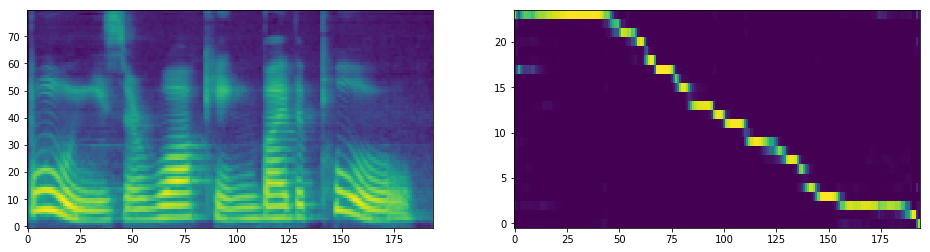

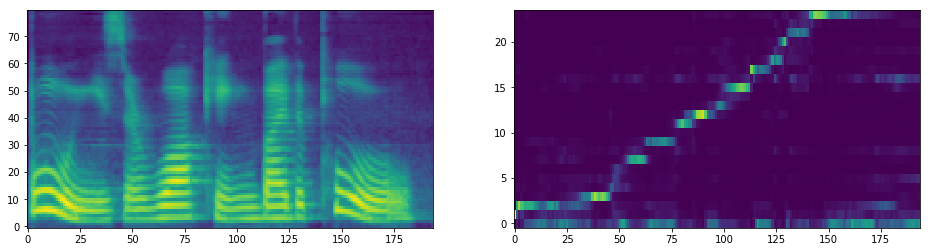

In [300]:
#@title Style Parameters. { display-mode: "form", run: "auto"}
style = "surprised" #@param ['angry', 'calm', 'disgust','fearful','happy','neutral','sad','surprised']
audio_numpy = infer_style()
print(sampling_rate)
Audio(audio_numpy, rate=sampling_rate, autoplay=True)